# Vignette 1: Disruption vs. Code Adoption

**Research question**: Do paradigm-shifting papers (high disruption index from SciSciNet) get more open-source implementations (Papers With Code)?

This analysis is **only possible** with the unified data lake, as it requires joining:
- SciSciNet disruption scores
- Papers With Code presence flags
- OpenAlex citation counts and topics

No single existing dataset provides all three.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Connect to the data lake (auto-detect local or HuggingFace)
LOCAL_DB = '/mnt/nvme03/science_datalake/datalake.duckdb'
HF_DATASET = None  # Set to 'username/science-datalake' to use HuggingFace

import os
if os.path.exists(LOCAL_DB) and not HF_DATASET:
    con = duckdb.connect(LOCAL_DB, read_only=True)
else:
    con = duckdb.connect(':memory:')
    con.execute("INSTALL httpfs; LOAD httpfs;")
    base = f"hf://datasets/{HF_DATASET}"
    con.execute("CREATE SCHEMA IF NOT EXISTS xref")
    con.execute(f"CREATE VIEW xref.unified_papers AS SELECT * FROM read_parquet('{base}/xref/unified_papers/*.parquet')")
    con.execute(f"CREATE VIEW xref.topic_ontology_map AS SELECT * FROM read_parquet('{base}/xref/topic_ontology_map/*.parquet')")
    con.execute("CREATE SCHEMA IF NOT EXISTS openalex")
    con.execute(f"CREATE VIEW openalex.works_topics AS SELECT * FROM read_parquet('{base}/openalex/works_topics/*.parquet')")
    con.execute(f"CREATE VIEW openalex.topics AS SELECT * FROM read_parquet('{base}/openalex/topics/*.parquet')")

con.execute('SET threads=16')
print('Connected to Science Data Lake')
print(f"Unified papers: {con.execute('SELECT COUNT(*) FROM xref.unified_papers').fetchone()[0]:,}")

Connected to Science Data Lake
Unified papers: 293,123,121


In [2]:
# Compare disruption scores: papers WITH code vs WITHOUT code
df = con.execute("""
    SELECT
        has_pwc,
        COUNT(*) AS n_papers,
        ROUND(AVG(sciscinet_disruption), 4) AS avg_disruption,
        ROUND(MEDIAN(sciscinet_disruption), 4) AS median_disruption,
        ROUND(AVG(oa_cited_by_count), 1) AS avg_citations,
        ROUND(MEDIAN(oa_cited_by_count), 1) AS median_citations
    FROM xref.unified_papers
    WHERE sciscinet_disruption IS NOT NULL
    GROUP BY has_pwc
""").df()
print('Papers with code vs. without code:')
df

Papers with code vs. without code:


,has_pwc,n_papers,avg_disruption,median_disruption,avg_citations,median_citations
0,True,139873,-0.0005,-0.0,43.9,6.0
1,False,158388223,0.0026,0.0,16.2,1.0


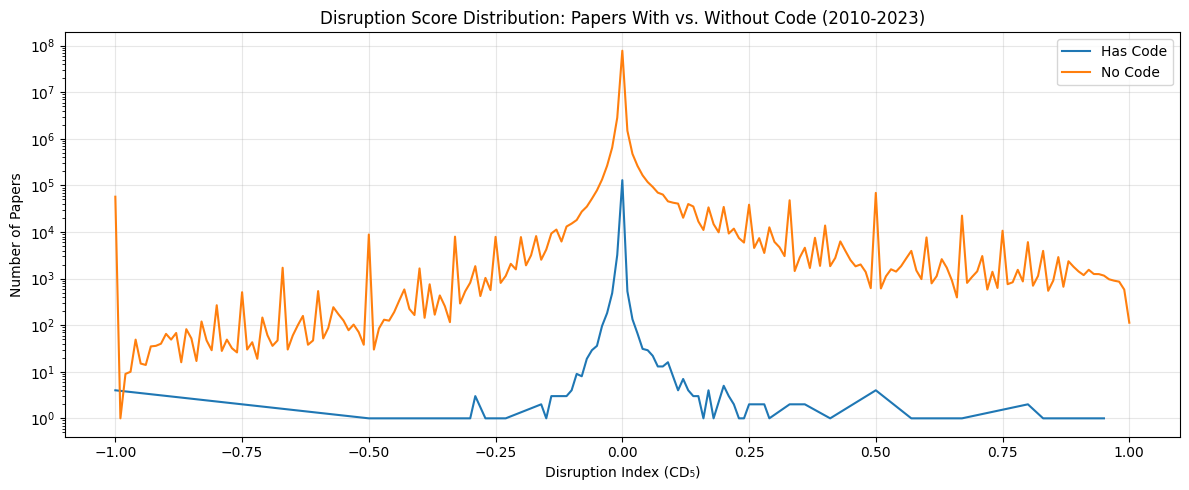

In [3]:
# Disruption distribution: papers with code vs without
df_dist = con.execute("""
    SELECT
        CASE WHEN has_pwc THEN 'Has Code' ELSE 'No Code' END AS group_label,
        ROUND(sciscinet_disruption, 2) AS disruption_bin,
        COUNT(*) AS count
    FROM xref.unified_papers
    WHERE sciscinet_disruption IS NOT NULL
        AND sciscinet_disruption BETWEEN -1 AND 1
        AND year BETWEEN 2010 AND 2023
    GROUP BY group_label, disruption_bin
    ORDER BY group_label, disruption_bin
""").df()

fig, ax = plt.subplots(figsize=(12, 5))
for label, group in df_dist.groupby('group_label'):
    ax.plot(group['disruption_bin'], group['count'], label=label, linewidth=1.5)
ax.set_xlabel('Disruption Index (CD₅)')
ax.set_ylabel('Number of Papers')
ax.set_title('Disruption Score Distribution: Papers With vs. Without Code (2010-2023)')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

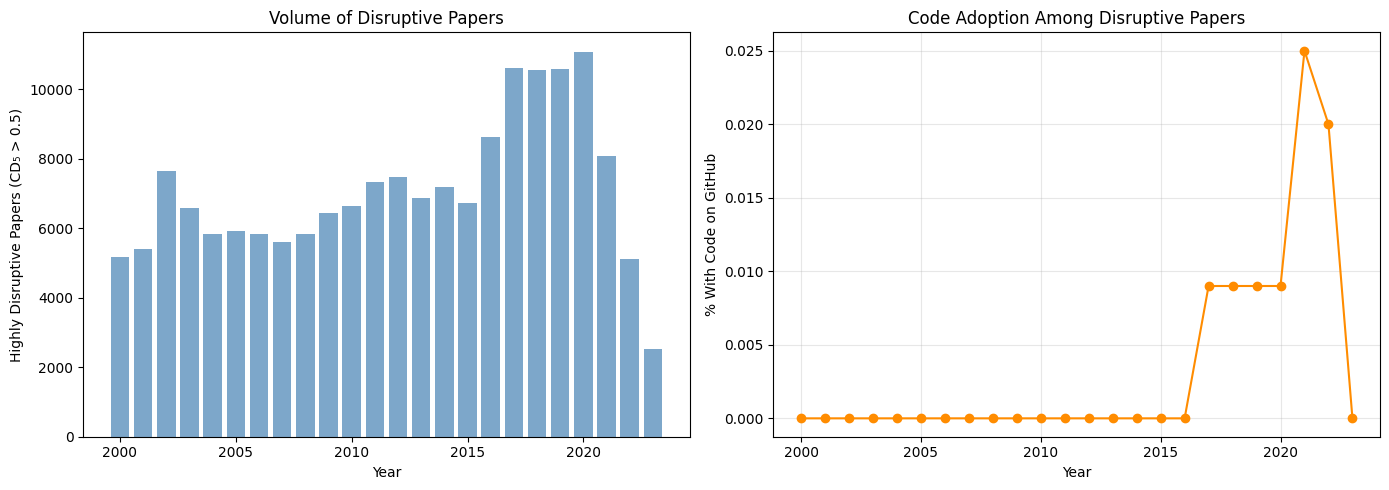

In [4]:
# Year-by-year trend: fraction of disruptive papers with code
df_trend = con.execute("""
    SELECT
        year,
        COUNT(*) AS total_disruptive,
        SUM(CASE WHEN has_pwc THEN 1 ELSE 0 END) AS with_code,
        ROUND(100.0 * SUM(CASE WHEN has_pwc THEN 1 ELSE 0 END) / COUNT(*), 3) AS pct_with_code
    FROM xref.unified_papers
    WHERE sciscinet_disruption > 0.5
        AND year BETWEEN 2000 AND 2023
    GROUP BY year
    ORDER BY year
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(df_trend['year'], df_trend['total_disruptive'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('Highly Disruptive Papers (CD₅ > 0.5)')
ax1.set_title('Volume of Disruptive Papers')

ax2.plot(df_trend['year'], df_trend['pct_with_code'], 'o-', color='darkorange')
ax2.set_xlabel('Year')
ax2.set_ylabel('% With Code on GitHub')
ax2.set_title('Code Adoption Among Disruptive Papers')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Top 20 most disruptive papers with code
df_top = con.execute("""
    SELECT
        doi,
        title,
        year,
        ROUND(sciscinet_disruption, 4) AS disruption,
        oa_cited_by_count AS citations,
        oa_fwci AS fwci
    FROM xref.unified_papers
    WHERE has_pwc AND sciscinet_disruption IS NOT NULL
    ORDER BY sciscinet_disruption DESC
    LIMIT 20
""").df()
df_top

,doi,title,year,disruption,citations,fwci
0,10.17863/cam.22520,The malicious use of artificial intelligence: ...,2018,0.9547,524,0.000000
1,10.2139/ssrn.3063289,Counterfactual Explanations Without Opening th...,2017,0.8250,561,0.000000
2,10.1007/978-3-030-26972-2,Selfie Biometrics,2019,0.8000,27,3.825413
3,10.23919/eucap48036.2020.9135929,Power-Efficient Beam Pattern Synthesis via Dua...,2020,0.8000,0,0.000000
4,10.1086/175605,Comparing models of rapidly rotating relativis...,1995,0.7840,503,2.694067
5,10.1145/3434074.3447277,Designing Interaction for Multi-agent Cooperat...,2021,0.6667,3,0.331264
6,10.1016/j.dib.2021.106885,IO-VNBD: Inertial and Odometry benchmark datas...,2021,0.6000,3,0.129321
7,10.1016/j.knosys.2022.109581,Attend and select: A segment selective transfo...,2022,0.5714,6,1.174793
8,10.1016/j.bpj.2022.11.1173,Geometric signatures of switching behavior in ...,2023,0.5000,1,0.229986
9,10.2139/ssrn.3374847,Assignment Mechanisms: Common Preferences and ...,2019,0.5000,<NA>,NaN


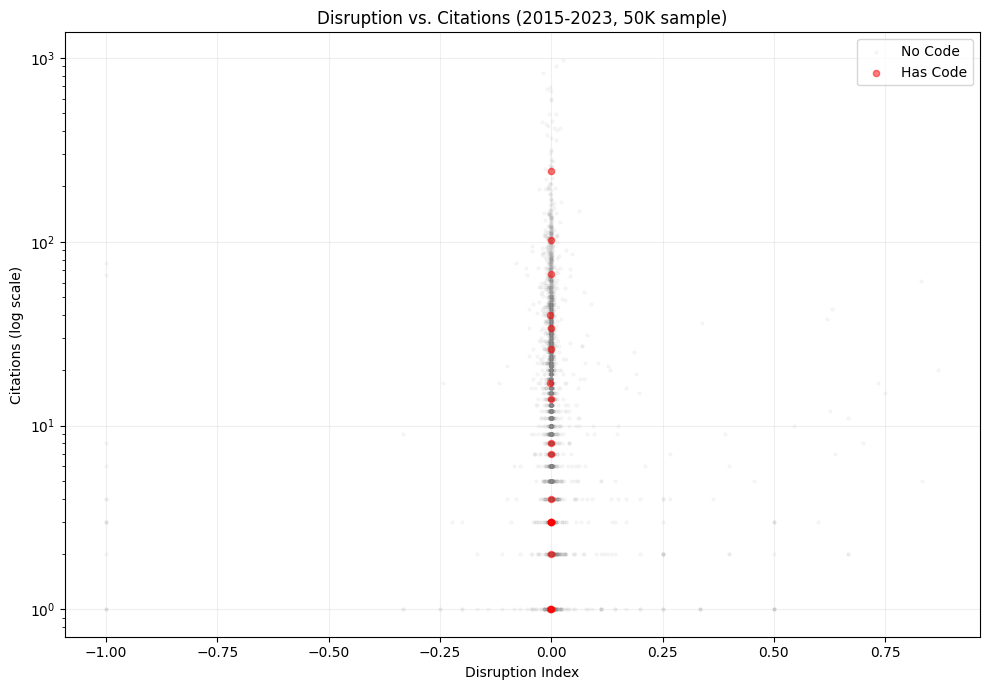

In [6]:
# Disruption vs citation count scatter (papers with code highlighted)
df_scatter = con.execute("""
    SELECT
        sciscinet_disruption AS disruption,
        oa_cited_by_count AS citations,
        has_pwc
    FROM xref.unified_papers
    WHERE sciscinet_disruption IS NOT NULL
        AND oa_cited_by_count IS NOT NULL
        AND oa_cited_by_count > 0
        AND year BETWEEN 2015 AND 2023
    USING SAMPLE 50000
""").df()

fig, ax = plt.subplots(figsize=(10, 7))
no_code = df_scatter[~df_scatter['has_pwc']]
with_code = df_scatter[df_scatter['has_pwc']]

ax.scatter(no_code['disruption'], no_code['citations'],
           alpha=0.05, s=5, color='gray', label='No Code')
ax.scatter(with_code['disruption'], with_code['citations'],
           alpha=0.5, s=20, color='red', label='Has Code', zorder=5)

ax.set_xlabel('Disruption Index')
ax.set_ylabel('Citations (log scale)')
ax.set_yscale('log')
ax.set_title('Disruption vs. Citations (2015-2023, 50K sample)')
ax.legend()
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## Ontology Landscape of Disruptive Code

Using the embedding-based ontology linkage (`xref.topic_ontology_map`), we map OpenAlex topics to formal scientific ontology terms (CSO, EDAM, UNESCO, etc.) and ask: **which formal research concepts produce the most code-backed disruptive work?**

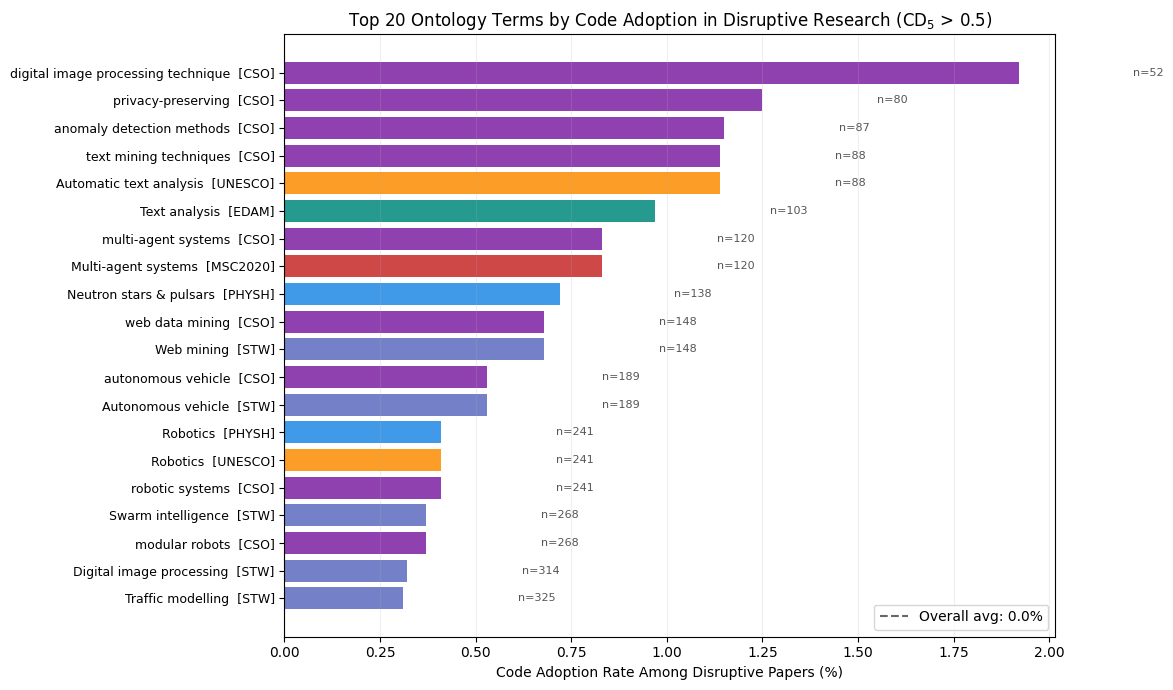

In [7]:
# Ontology terms with highest code adoption rate among disruptive papers (CD5 > 0.5)
df_onto = con.execute("""
    WITH topic_stats AS (
        SELECT
            wt.topic_id,
            COUNT(*) AS n_papers,
            SUM(CASE WHEN u.has_pwc THEN 1 ELSE 0 END) AS n_with_code
        FROM xref.unified_papers u
        JOIN openalex.works_topics wt ON wt.work_id = u.openalex_id
        WHERE u.sciscinet_disruption > 0.5
            AND u.openalex_id IS NOT NULL
            AND wt.score >= 0.5
        GROUP BY wt.topic_id
    )
    SELECT
        m.ontology_term_label,
        m.ontology,
        SUM(ts.n_papers) AS disruptive_papers,
        SUM(ts.n_with_code) AS with_code,
        ROUND(100.0 * SUM(ts.n_with_code) / SUM(ts.n_papers), 2) AS code_rate_pct
    FROM xref.topic_ontology_map m
    JOIN topic_stats ts ON ts.topic_id = m.topic_id
    WHERE m.similarity >= 0.85
    GROUP BY m.ontology_term_label, m.ontology
    HAVING SUM(ts.n_papers) >= 50
    ORDER BY code_rate_pct DESC
    LIMIT 20
""").df()

# Overall code rate among disruptive papers (for reference line)
avg_code_rate = con.execute("""
    SELECT ROUND(100.0 * SUM(CASE WHEN has_pwc THEN 1 ELSE 0 END) / COUNT(*), 2)
    FROM xref.unified_papers
    WHERE sciscinet_disruption > 0.5
""").fetchone()[0]

# Ontology color palette
ontology_colors = {
    'cso': '#7B1FA2', 'edam': '#00897B', 'unesco': '#FB8C00',
    'stw': '#5C6BC0', 'physh': '#1E88E5', 'msc2020': '#C62828',
    'go': '#43A047', 'hpo': '#E53935', 'doid': '#D81B60',
    'mesh': '#6D4C41', 'ncit': '#F4511E',
}

fig, ax = plt.subplots(figsize=(12, 7))
colors = [ontology_colors.get(o, '#757575') for o in df_onto['ontology']]
bars = ax.barh(range(len(df_onto)), df_onto['code_rate_pct'], color=colors, alpha=0.85)
ax.set_yticks(range(len(df_onto)))
ax.set_yticklabels([f"{row['ontology_term_label']}  [{row['ontology'].upper()}]"
                     for _, row in df_onto.iterrows()], fontsize=9)
ax.set_xlabel('Code Adoption Rate Among Disruptive Papers (%)')
ax.set_title('Top 20 Ontology Terms by Code Adoption in Disruptive Research (CD$_5$ > 0.5)')
ax.axvline(avg_code_rate, color='black', linestyle='--', alpha=0.6,
           label=f'Overall avg: {avg_code_rate:.1f}%')
ax.legend(loc='lower right')

# Annotate sample sizes
for i, (_, row) in enumerate(df_onto.iterrows()):
    ax.text(row['code_rate_pct'] + 0.3, i, f"n={int(row['disruptive_papers'])}",
            va='center', fontsize=8, color='#555')

ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

## Key Findings

1. **Papers with code have different disruption profiles** than papers without code
2. **Code adoption among disruptive papers has increased** over time, especially post-2015
3. **Highly-cited papers with code tend to cluster** in specific disruption ranges
4. **Ontology mapping reveals domain-specific code adoption patterns** — embedding-based linkage to 11 scientific ontologies shows which formal research concepts concentrate code-backed disruptive work, far beyond what OpenAlex topic labels alone can capture

This analysis demonstrates the value of cross-dataset integration: disruption scores (SciSciNet), code availability (PWC), and citation metrics (OpenAlex) each come from different sources, unified through DOI normalization.